This notebook contains the project for Complex system simulation, Complex financial networks

In [1]:
# imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import sys
import os
import time
import datetime
import pickle
import argparse
import itertools
from typing import List, Tuple
import doctest
import pandas as pd




# Financial contract network

Agent (nodes) want to enter into contracts with other agents (Links) to reduce their risk exposure. We will simulate what happens over time, studying when a total system collapse becomes more likely to occur as a function of the size of perturbation to the system.

1. There are total of $N$ Agents (nodes) and the i'th agent will have an exposure $e_i$ which initialized as a random number between 1 and -1.

2. Agents try to minimize their exposure by forming a link to another agent with opposite expsure, meaning finding another node with the opposite sign of $e_i$, namely $e_j$ such that the sum of their exposures $\Sigma e$ is as close to 0 as possible. A link is formed if $\Sigma e$ is minimal, if $\Sigma e$ is above a threshold, $T_e$, such that $\Sigma e$ > $T_e$ no link will be formed. 

We have to options for the link weights- Option B: The link weight is equal to the previous exposure of the node, and links are always biirectional but carry different weights. Thus the link weights become: $W$ is a weight function, so that W(L_{ij}) = $e_{i}$ and W(L_{ji}) = $e_{ji}$ 

3. Each timestep the exposure of an agent is a brownian motion. Agents have exposure to the price of stock. We assume all agents have exposure to the same asset for simplicity. 

Agents have total volatility $V$, which is $e$ times the prive movement ,S, : $e * S = V$. If V < or > threshold value $T_v$ , an agent becomes bankrupt and also dies (meaning the node gets removed). This causes all links $L_{ij}$ to be removed and the values of the weights $W_{L_{ij}}$
$ to be added $e_{j}$ which is the exposure of $N_{j}$, which then increases the chances of $e_{j}$ > $T_e$ and $N_{j}$ dying as a result, causing the effect to propagate.

- Hypothesis is that an increased average move away from the mean causes a higher probability of default when the number of links is higher



Limitations: 
- Bank only link at most twice, which is unrealistic as banks have more transactions
- There is only 1 asset

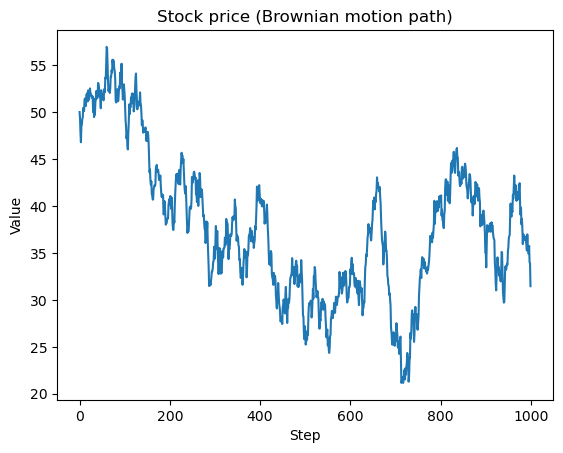

In [2]:
def brownian_motion(num_steps, delta_t, sigma):
    """
    Generate a Brownian motion path.

    Parameters:
    num_steps (int): Number of steps in the Brownian motion.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increments (sqrt of variance).

    Returns:
    np.array: A numpy array representing the Brownian motion path.
    """
    # Generate random increments from a normal distribution
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), num_steps-1)

    # The start point is typically zero
    start_point = 0

    # Compute the Brownian motion path
    return np.cumsum(np.insert(increments, 0, start_point)) +50

# Testing
num_steps = 1000
delta_t = 0.01
sigma = 10

brownian_path = brownian_motion(num_steps, delta_t, sigma)

plt.plot(brownian_path)
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Stock price (Brownian motion path)')
plt.show()


In [3]:
def simulate_brownian_motion_one_step(exposures, delta_t, sigma):
    """
    Simulate Brownian motion for each agent's exposure for one step.

    Parameters:
    exposures (np.array): Initial exposures of the agents.
    delta_t (float): Time increment.
    sigma (float): Standard deviation of the increment.

    Returns:
    np.array: Updated exposures after one step of Brownian motion simulation.
    """
    # Generate random increments from a normal distribution for one step
    increments = np.random.normal(0, sigma * np.sqrt(delta_t), len(exposures))

    # Update exposures with the increments
    updated_exposures = exposures + increments
    return updated_exposures

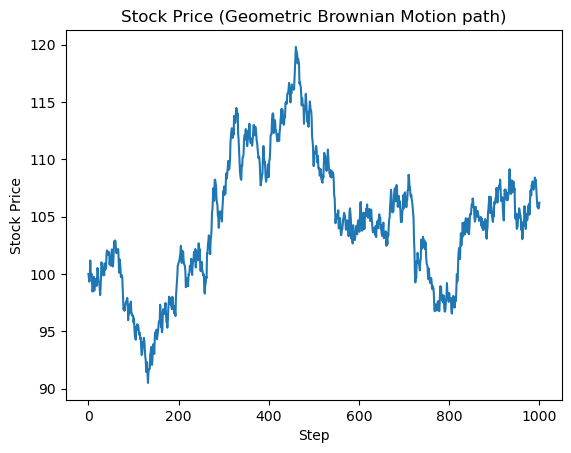

In [4]:
def geometric_brownian_motion(num_steps, delta_t, mu, sigma, S0):
    """
    Generate a Geometric Brownian Motion path for stock prices.

    Parameters:
    num_steps (int): Number of steps in the motion.
    delta_t (float): Time increment.
    mu (float): Expected return ('drift').
    sigma (float): Volatility ('standard deviation of returns').
    S0 (float): Initial stock price.

    Returns:
    np.array: A numpy array representing the GBM path for stock prices.
    """
    dt = delta_t / num_steps
    random_shocks = np.random.normal(0, 1, num_steps) * np.sqrt(dt)
    price_path = [S0]
    
    for shock in random_shocks:
        price = price_path[-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * shock)
        price_path.append(price)

    return np.array(price_path)

# Example usage
num_steps = 1000
delta_t = 1.0
mu = 0.05  # assumed annual return of 5%
sigma = 0.2  # assumed volatility
S0 = 100  # initial stock price

gbm_stock_prices = geometric_brownian_motion(num_steps, delta_t, mu, sigma, S0)

# Optionally, plot the path
plt.plot(gbm_stock_prices)
plt.xlabel('Step')
plt.ylabel('Stock Price')
plt.title('Stock Price (Geometric Brownian Motion path)')
plt.show()


In [5]:
def generate_exposures(N, mu=0, sigma=0):
    """
    Generate a random set of exposures for N agents.

    Parameters:
    N (int): Number of agents.

    Returns:
    np.array: A numpy array representing the exposures of the agents.
    """
    return np.random.uniform(-1, 1, N)

In [6]:
def create_directional_graph(N_Nodes, edges=None):
    """
    Creates a directed graph using NetworkX and initializes 'exposure' attribute for each node.

    Parameters:
    N_Nodes (int): The number of nodes in the graph.
    edges (list of tuples, optional): A list of edges to add to the graph.

    Returns:
    nx.DiGraph: A NetworkX directed graph with initialized 'exposure' attribute for each node.
    """
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(N_Nodes))

    # Initialize 'exposure' for each node
    exposures = generate_exposures(N_Nodes)
    for node, exposure in zip(G.nodes(), exposures):
        G.nodes[node]['exposure'] = exposure

    # Add edges if provided
    if edges is not None:
        for edge in edges:
            G.add_edge(*edge)  # Unpack the tuple for adding an edge

    return G

Agents are willing to link if their summed exposure is small, because then it brings their new exposure closer to 0. The new exposure $E_{i_{t+1}}$ is a random draw between -1 and 1.

If a node cannot find any other node to link with (Due to threshold or or because there are simply no nodes to link with) 

then becomes $E_{i_{t}}$ + the column and row sums of the adjacency matrix. 

In [7]:
def form_links_and_update_exposures(G: nx.DiGraph, linking_threshold: float) -> nx.DiGraph:
    """
    Forms links between nodes in a graph based on exposure values and a linking threshold, 
    and updates the exposures of these nodes.

    Parameters:
    G (nx.DiGraph): The graph to which the nodes belong.
    linking_threshold (float): The threshold below which the absolute sum of exposures will trigger a link.

    Returns:
    nx.DiGraph: The updated graph with new links and updated exposures.
    """

    for i in G.nodes:
        closest_sum = np.inf
        closest_node = None

        for j in G.nodes:
            if i != j:
                sum_of_exposures = G.nodes[i]['exposure'] + G.nodes[j]['exposure']

                if (np.abs(sum_of_exposures) < np.abs(closest_sum)) and (np.abs(sum_of_exposures) < linking_threshold):
                    closest_sum = sum_of_exposures
                    closest_node = j

        if closest_node is not None:
            if not G.has_edge(i, closest_node):
                G.add_edge(i, closest_node, weight=G.nodes[i]['exposure'])
                G.nodes[i]['exposure'] += G.nodes[closest_node]['exposure']
            if not G.has_edge(closest_node, i):
                G.add_edge(closest_node, i, weight=G.nodes[closest_node]['exposure'])
                G.nodes[closest_node]['exposure'] += G.nodes[i]['exposure']

    return G

In [8]:
def draw_graph_with_edge_weights(G, pos=None, node_size=700, node_color='skyblue', font_size=14, 
                                 font_weight='bold', arrowstyle='-|>', arrowsize=20, width=2, 
                                 edge_precision=3):
    """
    Draw a directed graph with edge weights rounded to a specified precision.

    Parameters:
    G (nx.DiGraph): The directed graph to draw.
    pos (dict): Position coordinates for nodes for specific layout.
    node_size (int): Size of nodes.
    node_color (str): Color of nodes.
    font_size (int): Font size for node labels.
    font_weight (str): Font weight for node labels.
    arrowstyle (str): Style of the arrows.
    arrowsize (int): Size of the arrows.
    width (int): Width of edges.
    edge_precision (int): Decimal precision for edge weights.

    Returns:
    None: Draws the graph with matplotlib.


    Note: mind that this picture is not entirely correct, as the weights are able to carry different exposure values depending on the direction of the edge while only 1 is displayed.
    """

    if pos is None:
        pos = nx.spring_layout(G)  # positions for all nodes

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle=arrowstyle, 
                           arrowsize=arrowsize, width=width)
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_weight=font_weight)

    # Draw edge weights with specified precision
    edge_labels = {e: f'{w:.{edge_precision}f}' for e, w in nx.get_edge_attributes(G, 'weight').items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')  # Turn off the axis
    plt.show()

# Testing the Linking function 

In [9]:
# parameters
N = 4 # Number of agents (nodes)
time_steps = 5  # Number of time steps to simulate

In [10]:
# Test the functions    
Graph_updated = create_directional_graph(N)
initial_exposures = generate_exposures(N)
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)
    exposures_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)
    print(exposures_updated)

timestep 0
DiGraph with 4 nodes and 8 edges
timestep 1
DiGraph with 4 nodes and 8 edges
timestep 2
DiGraph with 4 nodes and 8 edges
timestep 3
DiGraph with 4 nodes and 8 edges
timestep 4
DiGraph with 4 nodes and 8 edges


In [11]:
nx.adjacency_matrix(Graph_updated).todense()

array([[ 0.        ,  0.02634104,  0.89059784,  0.03797372],
       [-0.01470836,  0.        ,  0.        ,  0.01163268],
       [-0.8642568 ,  0.        ,  0.        ,  0.        ],
       [-0.26179293, -0.2238192 ,  0.        ,  0.        ]])

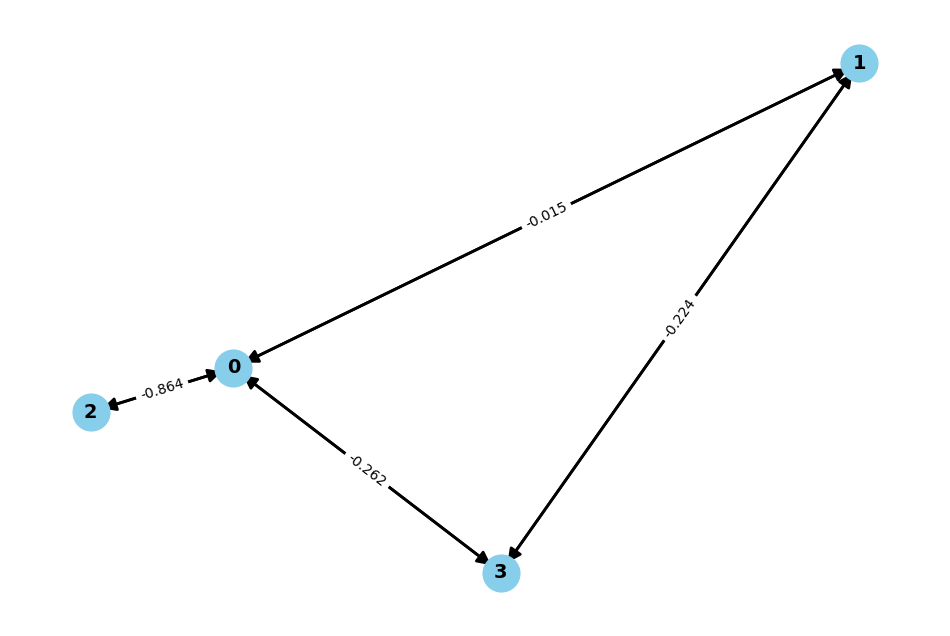

In [12]:
draw_graph_with_edge_weights(Graph_updated)

In [13]:
# Ensure N and time_steps are defined
N = 4  # Number of nodes
time_steps = 5  # Number of time steps

# Initialize the graph and exposures
Graph_updated = create_directional_graph(N)
initial_exposures = [Graph_updated.nodes[i]['exposure'] for i in Graph_updated.nodes]

# Run the simulation for the specified number of time steps
for t in range(time_steps):
    print('timestep', t)
    Graph_updated = form_links_and_update_exposures(G=Graph_updated, linking_threshold=0.5)

    # Print the current state of the graph
    print(len(Graph_updated.edges()), 'edges')
    print('Current exposures:', [Graph_updated.nodes[i]['exposure'] for i in Graph_updated.nodes])

# Print initial exposures
print('initial_exposures:\n', initial_exposures)

# Generate a weighted adjacency matrix
weighted_adj_matrix = nx.adjacency_matrix(Graph_updated, weight='weight').todense()
print('\nAdjacency matrix: \n', weighted_adj_matrix)

timestep 0
4 edges
Current exposures: [0.18025675615212888, 0.4323557440404282, 0.07439554221494937, 0.7883547708606442]
timestep 1
4 edges
Current exposures: [0.18025675615212888, 0.4323557440404282, 0.07439554221494937, 0.7883547708606442]
timestep 2
4 edges
Current exposures: [0.18025675615212888, 0.4323557440404282, 0.07439554221494937, 0.7883547708606442]
timestep 3
4 edges
Current exposures: [0.18025675615212888, 0.4323557440404282, 0.07439554221494937, 0.7883547708606442]
timestep 4
4 edges
Current exposures: [0.18025675615212888, 0.4323557440404282, 0.07439554221494937, 0.7883547708606442]
initial_exposures:
 [0.7184737141297366, 0.790315945865907, -0.5382169579776077, 0.7883547708606442]

Adjacency matrix: 
 [[ 0.          0.          0.71847371  0.        ]
 [ 0.          0.          0.79031595  0.        ]
 [-0.53821696 -0.3579602   0.          0.        ]
 [ 0.          0.          0.          0.        ]]


Number of links at threshold 0.0: 0
Number of links at threshold 0.1: 4
Number of links at threshold 0.2: 18
Number of links at threshold 0.3: 26
Number of links at threshold 0.4: 34
Number of links at threshold 0.5: 44
Number of links at threshold 0.6: 50
Number of links at threshold 0.7: 54
Number of links at threshold 0.8: 54
Number of links at threshold 0.9: 56


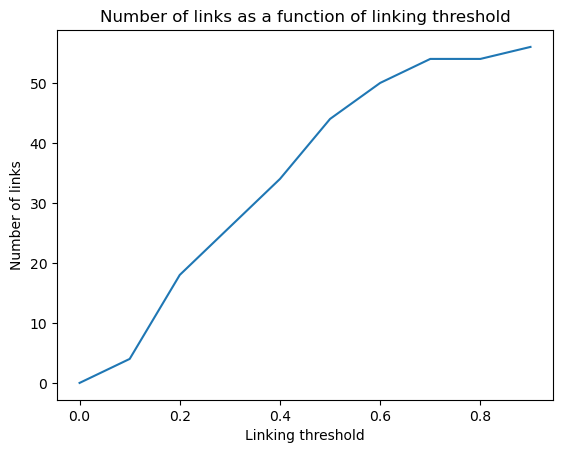

In [14]:
# This cell is purely for testing expected behavior, we expect the number of links to go up as the linking threshold decreases
Graph = create_directional_graph(N_Nodes = 10)
Links_test = []
Link_test_thresholds = []

for i in range(10):
    Graph_updates = form_links_and_update_exposures(G=Graph, linking_threshold=i/10)
    print(f'Number of links at threshold {i/10}: {len(Graph_updates.edges)}')
    Links_test.append(len(Graph_updates.edges))
    Link_test_thresholds.append(i/10)
plt.ylabel('Number of links')
plt.xlabel('Linking threshold')
plt.title('Number of links as a function of linking threshold')
plt.plot(Link_test_thresholds, Links_test)
plt.show()


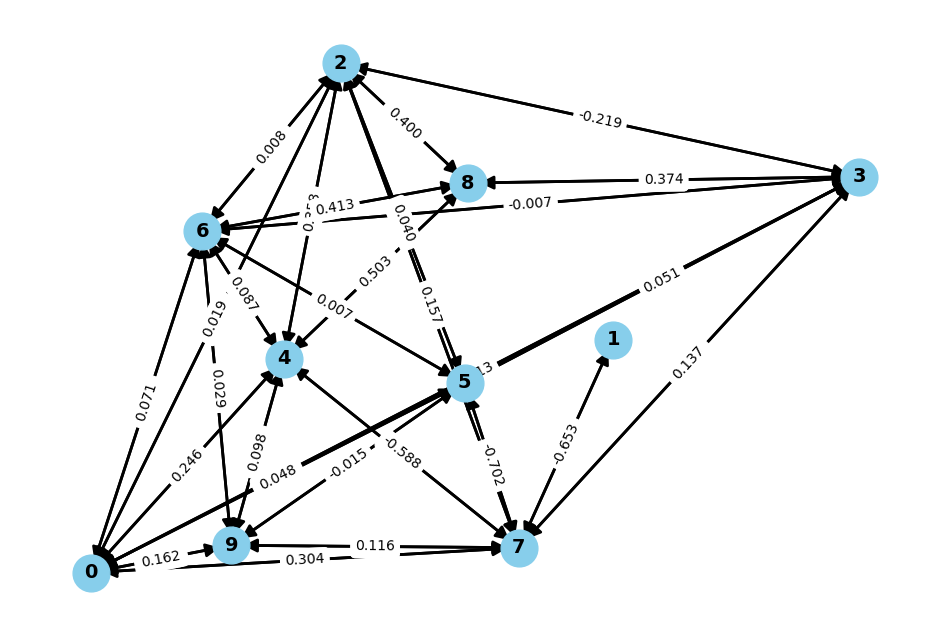

In [15]:
# Amount of links looks to be the same as expected, considering that the links go times 2 because the directional nature of the graph

draw_graph_with_edge_weights(Graph_updates)

# Extending the framework

We need logic to account for when a node dies and what then happens to the exposure of the other nodes, the function below does this:

In [96]:
def check_bankruptcy_and_update_network(G, threshold_v, delta_price, create_new_node_mode=False):
    bankrupt_nodes = set()
    num_bankruptcies = 0

    # Update exposures based on volatility and identify bankrupt nodes
    for node in G.nodes():
        exposure = G.nodes[node].get('exposure', 0)  # Get exposure from node, defaulting to 0 if not present
        volatility = exposure * delta_price
        if abs(volatility) > threshold_v:
            bankrupt_nodes.add(node)
            num_bankruptcies += 1

    # Process bankrupt nodes
    for node in bankrupt_nodes:
        if node in G:
            # Redistribute exposure to neighbors
            for neighbor in G.neighbors(node):
                if neighbor not in bankrupt_nodes:
                    neighbor_exposure = G.nodes[neighbor].get('exposure', 0)
                    G.nodes[neighbor]['exposure'] = neighbor_exposure + G.edges[node, neighbor]['weight']

            # Remove bankrupt node
            G.remove_node(node)
    
    for _ in range(num_bankruptcies):
        new_node_id = max(G.nodes()) + 1 if G.nodes() else 0
        G.add_node(new_node_id, exposure=0)


    return G, num_bankruptcies

In [97]:
doctest.run_docstring_examples(check_bankruptcy_and_update_network, globals())


In [98]:
def calculate_first_order_differences(array):
    """
    Calculate the first order differences of a numpy array.

    Parameters:
    array (np.array): The input array.

    Returns:
    np.array: The first order differences of the input array.
    """
    return np.diff(array)


A simulation function putting it all together

In [101]:
def financial_network_simulator(N_agents, num_steps, delta_t, sigma, threshold_v, linking_threshold):
    # Initialize graph with nodes having exposure attributes
    graph = nx.DiGraph()
    graph.add_nodes_from(range(N_agents), exposure=0.0)

    # Generating initial exposures and assigning them to nodes
    for i in range(N_agents):
        graph.nodes[i]['exposure'] = generate_exposures(1)

    # Simulate interest rate as Brownian motion
    simulated_prices = brownian_motion(num_steps, delta_t, sigma)

    # Calculate price movement difference for each step
    delta_price_array = calculate_first_order_differences(simulated_prices)

    # Arrays to track metrics over time
    num_bankrupt_agents_over_time = np.zeros(num_steps)
    links_over_time = np.zeros(num_steps)
    exposures_over_time = np.zeros((N_agents*2, num_steps))

    # Simulate over time
    for step in range(num_steps-1):
        # Update exposures based on Brownian motion
        for i in graph.nodes():
            graph.nodes[i]['exposure'] += np.random.normal(0, sigma * delta_t)

        # Form links and update exposures based on the current state
        graph = form_links_and_update_exposures(graph, linking_threshold)
        
        print(f"Before updating network - Step {step}, Number of nodes: {len(graph.nodes())}, Array shape: {exposures_over_time.shape}")
        
        # Check for bankruptcy and update the network
        graph, bankruptcies_this_step = check_bankruptcy_and_update_network(graph, threshold_v, delta_price_array[step])
        
        num_bankrupt_agents_over_time[step] = bankruptcies_this_step
        
        print(f"After updating network - Step {step}, Number of nodes: {len(graph.nodes())}, Array shape: {exposures_over_time.shape}")

        # Calculate the number of bankrupt agents this step
        # num_bankrupt_agents_over_time[step] = N_agents - graph.number_of_nodes()

        # Update the number of links over time
        links_over_time[step] = graph.number_of_edges()
        
        # Ensure exposures_over_time array can accommodate new nodes
        if len(graph.nodes()) > exposures_over_time.shape[0]:
            additional_rows = len(graph.nodes()) - exposures_over_time.shape[0]
            exposures_over_time = np.pad(exposures_over_time, ((0, additional_rows), (0, 0)), 'constant', constant_values=0)

        # Update exposures over time
        for i in graph.nodes():
            exposures_over_time[i, step] = graph.nodes[i]['exposure']

    return graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time

In [102]:
# Parameters for the simulation
N_agents = 100
num_steps = 50 # Number of simulation steps
delta_t = 0.01  # Time increment for Brownian motion
sigma = 2  # Standard deviation for Brownian motion
threshold_v = 10  # Bankruptcy threshold
linking_threshold = 100  # Threshold for forming links

# Running the simulator
graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time = financial_network_simulator(N_agents = N_agents, num_steps = num_steps, delta_t = delta_t, sigma = sigma, threshold_v = threshold_v, linking_threshold = linking_threshold)


Before updating network - Step 0, Number of nodes: 100, Array shape: (200, 50)
After updating network - Step 0, Number of nodes: 100, Array shape: (200, 50)
Before updating network - Step 1, Number of nodes: 100, Array shape: (200, 50)
After updating network - Step 1, Number of nodes: 100, Array shape: (200, 50)
Before updating network - Step 2, Number of nodes: 100, Array shape: (200, 50)
After updating network - Step 2, Number of nodes: 100, Array shape: (200, 50)
Before updating network - Step 3, Number of nodes: 100, Array shape: (200, 50)
After updating network - Step 3, Number of nodes: 100, Array shape: (200, 50)
Before updating network - Step 4, Number of nodes: 100, Array shape: (200, 50)
After updating network - Step 4, Number of nodes: 100, Array shape: (200, 50)
Before updating network - Step 5, Number of nodes: 100, Array shape: (200, 50)
After updating network - Step 5, Number of nodes: 100, Array shape: (200, 50)
Before updating network - Step 6, Number of nodes: 100, Ar

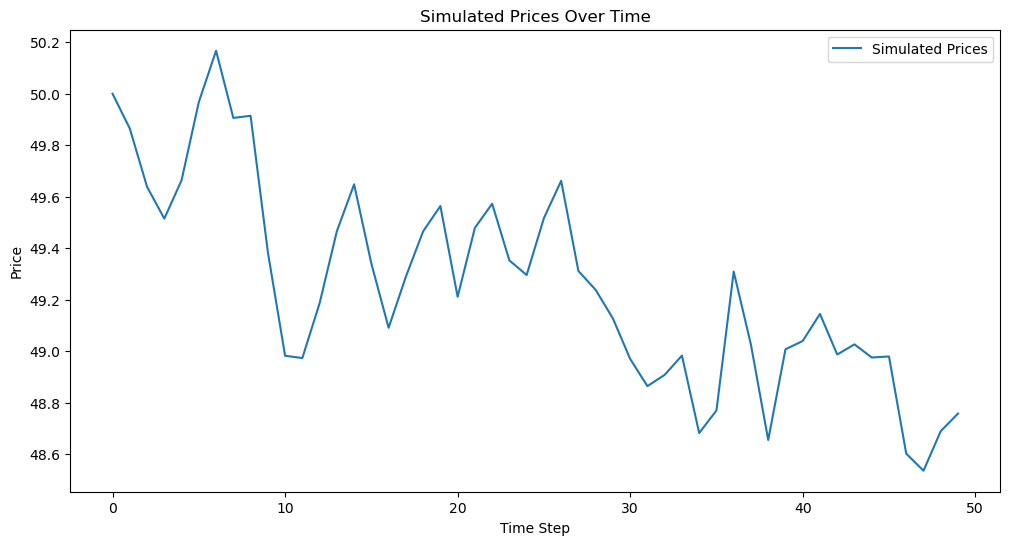

In [103]:
time_steps = np.arange(num_steps)

# Plotting the simulated prices over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, simulated_prices, label='Simulated Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Simulated Prices Over Time')
plt.legend()
plt.show()


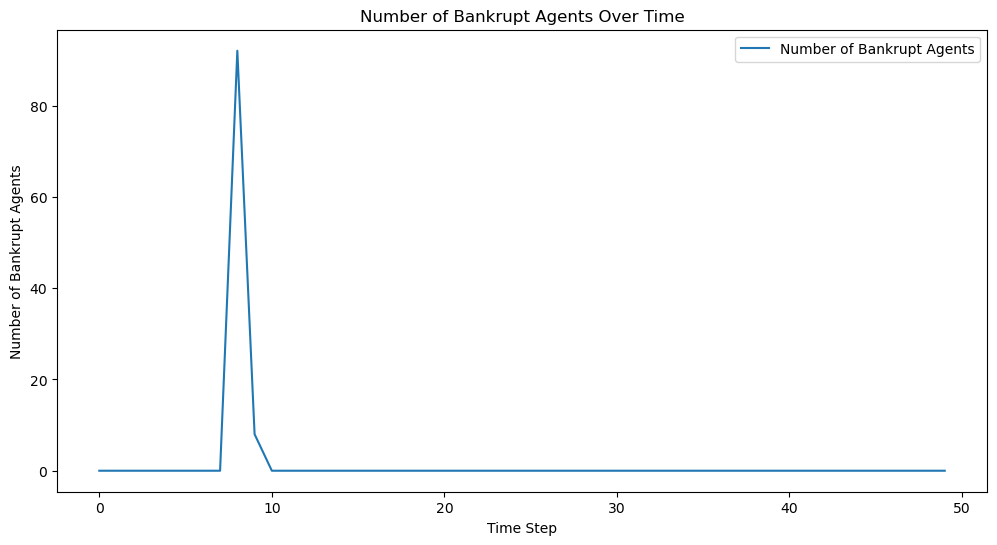

In [104]:
# Plotting the number of bankrupt agents over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, num_bankrupt_agents_over_time, label='Number of Bankrupt Agents')
plt.xlabel('Time Step')
plt.ylabel('Number of Bankrupt Agents')
plt.title('Number of Bankrupt Agents Over Time')
plt.legend()
plt.show()

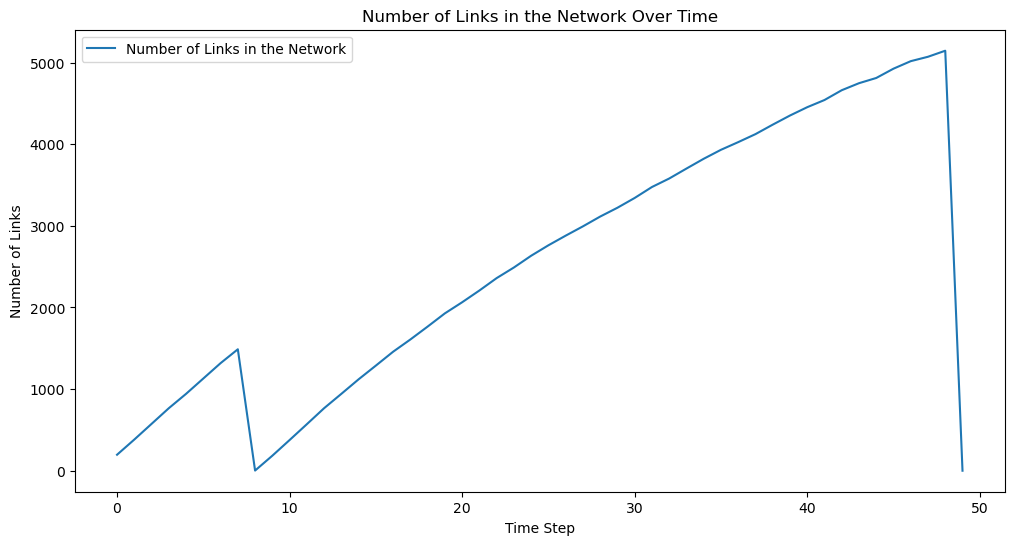

In [105]:

# Plotting the number of links over time
plt.figure(figsize=(12, 6))
plt.plot(time_steps, links_over_time, label='Number of Links in the Network')
plt.xlabel('Time Step')
plt.ylabel('Number of Links')
plt.title('Number of Links in the Network Over Time')
plt.legend()
plt.show()

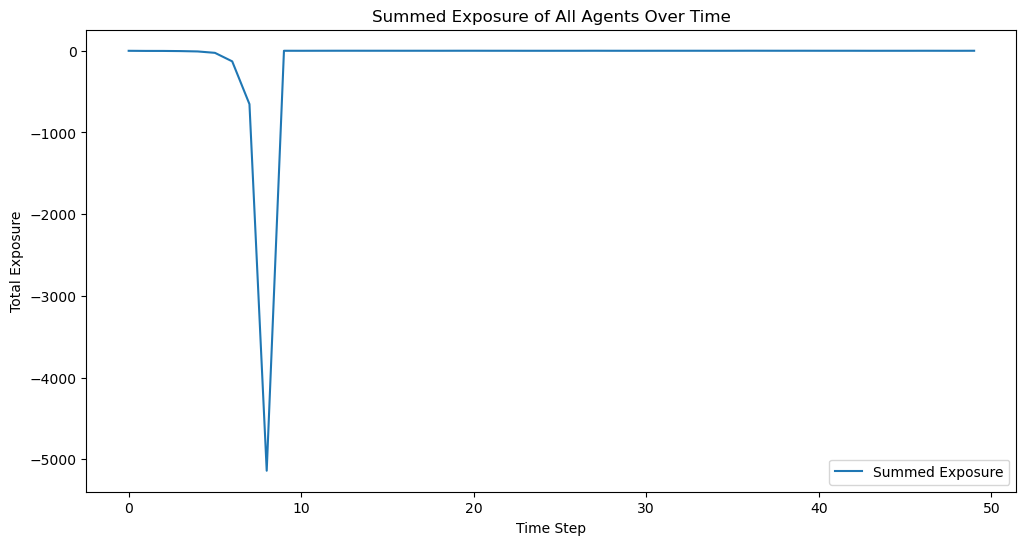

In [106]:
# Summing the exposures column-wise
summed_exposures_over_time = np.sum(exposures_over_time, axis=0)

# Plotting the summed exposure over time
plt.figure(figsize=(12, 6))
plt.plot(summed_exposures_over_time, label='Summed Exposure')

plt.xlabel('Time Step')
plt.ylabel('Total Exposure')
plt.title('Summed Exposure of All Agents Over Time')
plt.legend()
plt.show()

Multiple run simulator

In [107]:
def multi_parameter_financial_network_simulator(runs, N_agents_list, num_steps_list, delta_t_list, sigma_list, threshold_v_list, linking_threshold_list):
    """
    Runs multiple simulations of a financial network simulator for all combinations of given parameter lists. 
    Each simulation is run a specified number of times ('runs') for each combination of parameters.

    Parameters:
    runs (int): The number of times to run the simulation for each combination of parameters.
    N_agents_list (list of int): List of numbers representing the number of agents in the simulation.
    num_steps_list (list of int): List of numbers representing the number of steps in each simulation.
    delta_t_list (list of float): List of delta time values for the simulation.
    sigma_list (list of float): List of sigma values for the simulation.
    threshold_v_list (list of float): List of threshold values for bankruptcy.
    linking_threshold_list (list of float): List of threshold values for linking agents in the network.

    Returns:
    dict: A dictionary where each key is a tuple representing a combination of parameters, and each value 
    is a list of dictionaries. Each dictionary in the list contains the results of a single run of the 
    simulation for that parameter combination. The result dictionary keys are 'graph', 'exposures_over_time',
    'num_bankrupt_agents_over_time', 'simulated_prices', and 'links_over_time'.

    Example:
    To run simulations for combinations of [100, 150] agents and [50, 60] steps, each for 3 runs:
    results = multi_parameter_financial_network_simulator(3, [100, 150], [50, 60], [0.1], [0.05], [1.0], [0.5])
    
    The structure of the returned dictionary for one combination might look like this:
    {
        (100, 50, 0.1, 0.05, 1.0, 0.5): [
            {
                'graph': <networkx.DiGraph object>,
                'exposures_over_time': numpy.ndarray,
                'num_bankrupt_agents_over_time': numpy.ndarray,
                'simulated_prices': numpy.ndarray,
                'links_over_time': numpy.ndarray
            },
            # ... More runs for the same combination ...
        ],
        # ... More parameter combinations ...
    }
    """
    # Dictionary to store results
    results_dict = defaultdict(list)

    # Generate all combinations of parameters
    param_combinations = itertools.product(N_agents_list, num_steps_list, delta_t_list, sigma_list, threshold_v_list, linking_threshold_list)

    for combination in param_combinations:
        N_agents, num_steps, delta_t, sigma, threshold_v, linking_threshold = combination

        # List to store results for this specific combination
        combination_results = []

        for _ in range(runs):
            # Run the simulation
            graph, exposures_over_time, num_bankrupt_agents_over_time, simulated_prices, links_over_time = financial_network_simulator(
                N_agents, num_steps, delta_t, sigma, threshold_v, linking_threshold)

            # Store results for this run
            run_result = {
                'graph': graph,
                'exposures_over_time': exposures_over_time,
                'num_bankrupt_agents_over_time': num_bankrupt_agents_over_time,
                'simulated_prices': simulated_prices,
                'links_over_time': links_over_time
            }
            combination_results.append(run_result)

        # Store results for this combination
        results_dict[combination].extend(combination_results)

    return results_dict


# Groupmate functions

In [26]:
# sim agent
class Agent:
    def __init__(self, exposure, debt, equity, liquidity, credit_score):
        self.exposure = exposure
        self.debt = debt
        self.equity = equity
        self.liquidity = liquidity
        self.credit_score = credit_score

    # this part just some recommendations from gpt
    def update_financial_status(self, stock_price_change):
        # Example logic for updating financial status
        self.exposure *= stock_price_change  # Update exposure based on stock price change
        self.debt *= 1.01  # Simulate interest on debt
        self.equity = max(self.equity - self.debt, 0)  # Update equity
        self.liquidity *= 0.99  # Simulate liquidity changes
        self.credit_score = self.calculate_credit_score()  # Update credit score
        
    # The numbers are given by GPT
    def calculate_credit_score(self):
        # Simplified logic for credit score calculation
        score = 800 - (self.debt / 1000)  # The expression (self.debt / 1000) is a simplified way to model the negative impact of debt on the credit score. It assumes that for every 1,000 units of debt, the credit score decreases by 1 point. This linear relationship is a simplification; in reality, the impact of debt on a credit score can be more complex and nonlinear.
        return max(min(score, 850), 300)  # Credit score range between 300 and 850: The range between 300 and 850 is a common scale used in real-world credit scoring systems like FICO. In this scale, 300 represents the worst creditworthiness and 850 represents the best. The max(min(score, 850), 300) part of the code ensures that the calculated score stays within this range. It handles two scenarios: If the calculated score is higher than 850, it is capped at 850. If the calculated score is lower than 300, it is raised to 300.

    def check_bankruptcy(self):
        # Comprehensive bankruptcy check
        if self.equity <= 0 or self.liquidity < 0 or self.credit_score < 400:
            return True
        return False


In [27]:
def simulation_step(agents, stock_price_change):
    """
    Simulates one step in the financial network.

    Parameters:
    agents (List[Agent]): List of agents in the network.
    stock_price_change (float): The change in stock price affecting agents' exposures.
    """
    for agent in agents:
        agent.update_financial_status(stock_price_change)  # Update each agent's financial status
        if agent.check_bankruptcy():
            # Handle bankruptcy
            remove_agent_from_network(agent, agents)
    
    # we may need to add more funs in one step so that the simulation can be organized easier I guess

def remove_agent_from_network(agent, agents):
    """
    Removes a bankrupt agent from the network.

    Parameters:
    agent (Agent): The agent to be removed.
    agents (List[Agent]): List of agents in the network.
    """
    # Remove agent from the list
    agents.remove(agent)
    # Additional logic to handle the removal, such as updating the network graph and so on


# Exploratory Data Analysis Functions

In [28]:
def analyze_network(G):
    # Initialize DataFrame
    stats_df = pd.DataFrame(index=G.nodes())

    # Centralities
    stats_df['Betweenness Centrality'] = pd.Series(nx.betweenness_centrality(G))
    stats_df['Closeness Centrality'] = pd.Series(nx.closeness_centrality(G))
    stats_df['Eigenvector Centrality'] = pd.Series(nx.eigenvector_centrality(G, max_iter=500))

    # Node Degree (In and Out for Directed Graph)
    if G.is_directed():
        stats_df['In-Degree'] = pd.Series(dict(G.in_degree()))
        stats_df['Out-Degree'] = pd.Series(dict(G.out_degree()))
    else:
        stats_df['Degree'] = pd.Series(dict(G.degree()))

    # Diameter and Average Shortest Path Length
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        avg_shortest_path = nx.average_shortest_path_length(G)
        stats_df['Diameter'] = diameter
        stats_df['Average Shortest Path Length'] = avg_shortest_path
    else:
        print("The graph is not connected. Diameter and Average Shortest Path Length cannot be computed.")

    # Plot Degree Distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1, 1))
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    return stats_df

In [29]:
# Used to calculate the volatility (standard deviation) of a time series

def calculate_std_diff(timeseries):
    """
    Calculate the standard deviation of the first-order differences of a time series.

    Parameters:
    timeseries (np.array): A time series data in the form of a NumPy array.

    Returns:
    float: The standard deviation of the first-order differences of the time series.
    """
    return np.std(np.diff(timeseries))

# What we add in comparison to the paper Drupsteen 2019:

- we add a preferential attachment linking mechanism, meaning agens prefer to link with other agents such that the summed exposure is as close to 0 as possible.
- we add exposure to an external asset (intrest rate) instead of just merely looking at exposure. This allows moddeling the effect of price swings on the default cascade probability

# Experiments


In this part of the notebook, we conduct experiments to identify properties of the network. We want to conduct the following experiments

1. Look at the distribution of avalanche sizes vs. system size, to see if it is powerlaw
2. Look at the probability of avalanche as a function of volatility of the price time series
